In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,28.193,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,31.226,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.484,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,31.596,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,32.919,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


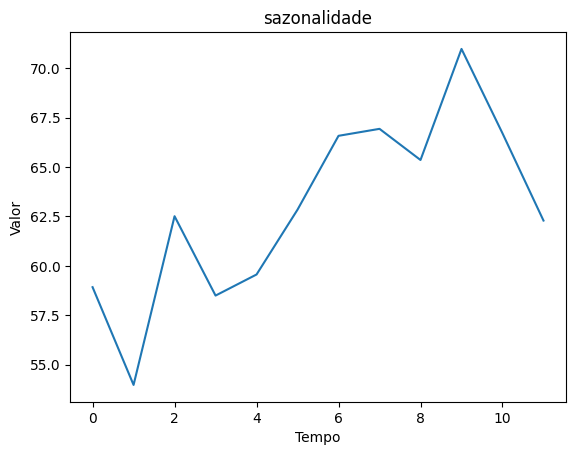

,sazonalidade
sazonalidade,
0,58.921869
1,53.975849
2,62.512451
3,58.496802
4,59.563075
5,62.845215
6,66.580630
7,66.933683
8,65.356944


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.921869,28.193
1,2003-2,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,53.975849,31.226
2,2003-3,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,62.512451,33.484
3,2003-4,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,58.496802,31.596
4,2003-5,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,59.563075,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.563075,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.845215,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.580630,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.933683,NaN


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 249, dtype: float64

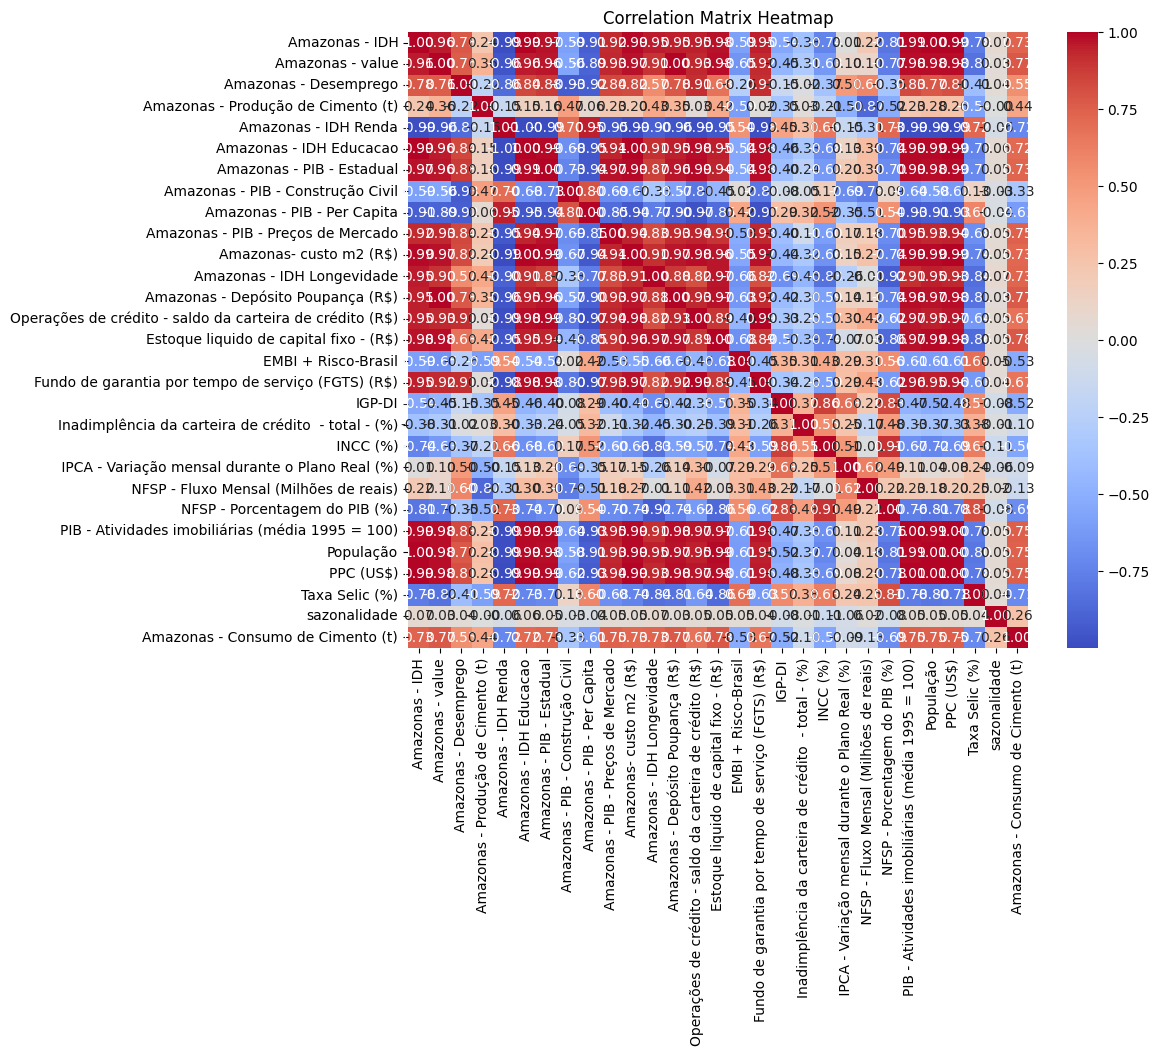

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amazonas - IDH,1.052287e+06
1,Amazonas - value,8.203293e+03
2,Amazonas - Desemprego,1.784579e+05
3,Amazonas - Produção de Cimento (t),7.119310e+02
4,Amazonas - IDH Renda,2.939573e+05
5,Amazonas - IDH Educacao,5.677497e+06
6,Amazonas - PIB - Estadual,1.528551e+08
7,Amazonas - PIB - Construção Civil,2.724699e+03
8,Amazonas - PIB - Per Capita,2.301728e+04
9,Amazonas - PIB - Preços de Mercado,3.915774e+04


In [40]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.330279,8.630942,51.313080,0.694618,4.754469e+07,2.519796e+06,4.318518e+07,11283.694800,0.745671,1.284537e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,58.921869
1,0.331137,8.624872,51.554195,0.694427,4.760190e+07,2.521321e+06,4.320154e+07,11377.134800,0.745986,1.291713e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,53.975849
2,0.331306,8.618803,51.523306,0.694236,4.765911e+07,2.522846e+06,4.321789e+07,11466.977022,0.746301,1.298888e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,62.512451
3,0.331791,8.612734,51.639628,0.694045,4.771632e+07,2.524370e+06,4.323425e+07,11551.599522,0.746616,1.306063e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,58.496802
4,0.332189,8.606665,51.838456,0.693854,4.777353e+07,2.525895e+06,4.325060e+07,11632.378833,0.746931,1.313239e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,59.563075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.560520,13.211809,48.396413,0.662343,5.547689e+07,2.440978e+06,4.414502e+07,22717.568032,0.766849,2.804978e+06,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,66.933683
152,0.555622,13.222159,48.190878,0.661764,5.550550e+07,2.440119e+06,4.414939e+07,22783.088872,0.767493,2.778098e+06,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,65.356944
153,0.551803,13.232510,48.095407,0.661185,5.553412e+07,2.439259e+06,4.415377e+07,22845.434259,0.768137,2.751217e+06,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,70.977677
154,0.547551,13.242860,48.065514,0.660606,5.556274e+07,2.438399e+06,4.415814e+07,22904.930677,0.768781,2.724336e+06,3.192250e+06,7.821333e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,66.707866


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.052171,0.201827,1.000000,0.000000,0.598708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.050926,0.216655,0.994480,0.007110,0.609805,0.016734,0.008000,0.013257,0.003507,0.000207,0.011007,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.049682,0.214755,0.988960,0.014220,0.620902,0.033468,0.015692,0.026515,0.007014,0.000221,0.022015,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.048437,0.221909,0.983440,0.021330,0.631999,0.050202,0.022937,0.039772,0.010520,0.000380,0.033022,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.047193,0.234137,0.977920,0.028440,0.643097,0.066935,0.029853,0.053030,0.014027,0.000881,0.044030,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.991510,0.022454,0.066969,0.985775,0.025029,0.982100,0.978924,0.891569,0.743087,0.980090,0.972006,0.341211,0.837927,0.143160,0.305639,0.047659,0.409150,0.997036,0.057396,0.993627,0.977394,0.411003
152,0.993633,0.009814,0.050227,0.989331,0.018772,0.986575,0.984534,0.918677,0.729950,0.985706,0.969670,0.361289,0.836471,0.149108,0.387048,0.021964,0.403230,0.993528,0.050845,0.994471,0.982733,0.324736
153,0.995755,0.003942,0.033485,0.992887,0.012514,0.991050,0.989871,0.945784,0.716812,0.991968,0.967333,0.383934,0.897087,0.106917,0.471089,0.021585,0.393004,0.972085,0.043758,0.995316,0.988182,0.456024
154,0.997878,0.002104,0.016742,0.996444,0.006257,0.995525,0.994965,0.972892,0.703675,0.997280,0.964997,0.399650,0.964383,0.074759,0.554626,0.015452,0.356091,0.963119,0.037052,0.993880,0.993896,0.381217


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.052171,0.201827,1.000000,0.000000,0.598708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.050926,0.216655,0.994480,0.007110,0.609805,0.016734,0.008000,0.013257,0.003507,0.000207,0.011007,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.049682,0.214755,0.988960,0.014220,0.620902,0.033468,0.015692,0.026515,0.007014,0.000221,0.022015,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.048437,0.221909,0.983440,0.021330,0.631999,0.050202,0.022937,0.039772,0.010520,0.000380,0.033022,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.047193,0.234137,0.977920,0.028440,0.643097,0.066935,0.029853,0.053030,0.014027,0.000881,0.044030,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.931443,0.242023,0.199549,0.939883,0.146137,0.956671,0.897764,0.716196,0.903778,0.881396,0.993211,0.145335,0.767121,0.369541,0.134802,0.160109,0.756416,0.799973,0.094876,0.999733,0.929945,0.302580
140,0.940485,0.220212,0.196472,0.944083,0.130675,0.955491,0.903783,0.713319,0.890032,0.891920,0.992241,0.149790,0.770809,0.373663,0.107661,0.168785,0.755278,0.803815,0.095765,0.999867,0.932690,0.229929
141,0.949527,0.198411,0.193395,0.948282,0.115214,0.954312,0.909886,0.710443,0.876287,0.904492,0.991271,0.156217,0.823469,0.383080,0.063009,0.169823,0.745299,0.692895,0.095412,1.000000,0.935504,0.334488
142,0.958569,0.176673,0.190318,0.952482,0.099752,0.953133,0.915942,0.707567,0.862541,0.916359,0.990301,0.164797,0.886163,0.372850,0.017943,0.168006,0.739572,0.764133,0.094477,0.997032,0.938403,0.291661


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      39.696000
1      56.005000
2      39.376000
3      59.327000
4      40.816000
         ...    
139    54.443714
140    53.771981
141    57.705930
142    53.900508
143    56.393500
Name: Amazonas - Consumo de Cimento (t), Length: 144, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 22)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.603944,0.977732,0.370470,0.744778,0.633685,0.870148,0.719919,0.756497,0.763640,0.584672,0.952818,0.046476,0.576729,0.241213,0.894461,0.269958,0.246811,0.011842,0.021268,0.788736,0.794730,0.126286
109,0.615686,0.962071,0.360861,0.753125,0.623069,0.880287,0.724470,0.756392,0.773926,0.592860,0.955785,0.049796,0.547631,0.257717,0.933771,0.247038,0.255042,0.061730,0.022371,0.801322,0.800825,0.136300
110,0.627429,0.946761,0.351253,0.761473,0.612453,0.890427,0.729046,0.756287,0.784211,0.603045,0.958752,0.050154,0.547834,0.301698,0.961400,0.246383,0.284608,0.066764,0.024066,0.813907,0.806817,0.198981
111,0.639171,0.928135,0.341644,0.769820,0.601836,0.900566,0.733537,0.756182,0.794496,0.613555,0.961720,0.048907,0.541336,0.299812,0.983561,0.261807,0.314835,0.043925,0.025253,0.826493,0.812425,0.124912
112,0.650913,0.938440,0.332035,0.778167,0.591220,0.910705,0.738120,0.756077,0.804781,0.623825,0.964687,0.044925,0.547192,0.255504,0.984745,0.316206,0.306260,0.095032,0.028261,0.839666,0.818016,0.032369
113,0.662655,0.911826,0.322427,0.786514,0.580604,0.920845,0.742352,0.755972,0.815066,0.633509,0.967654,0.039367,0.555211,0.207948,0.987221,0.266153,0.311235,0.101029,0.031624,0.852839,0.823761,0.039834
114,0.674397,0.903861,0.312818,0.794862,0.569988,0.930984,0.746289,0.755867,0.825351,0.642425,0.970622,0.033811,0.557537,0.169207,0.990146,0.267539,0.309980,0.105226,0.034133,0.866013,0.829544,0.042221
115,0.686139,0.874663,0.303209,0.803209,0.559372,0.941123,0.751203,0.755762,0.835636,0.652070,0.973589,0.026160,0.563561,0.122054,1.000000,0.243993,0.301380,0.132974,0.034686,0.878234,0.835366,0.092363
116,0.697881,0.852379,0.293601,0.811556,0.548756,0.951263,0.755168,0.755657,0.845921,0.662246,0.976556,0.018514,0.562394,0.079036,0.985009,0.240073,0.312886,0.163856,0.036283,0.890455,0.840978,0.158579
117,0.709623,0.827495,0.283992,0.819903,0.538139,0.961402,0.759152,0.755552,0.856207,0.675009,0.979524,0.010641,0.609785,0.065481,0.946695,0.238489,0.304865,0.176276,0.036400,0.902676,0.846397,0.091050


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 22)

In [48]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [49]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.2,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [50]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [51]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[883647641, 437302366, 502715384, 3162451060, 2816979936, 2013242857, 1359245283, 709509863, 112972603, 4077493435]


Step: 0 ___________________________________________
val_loss: 140.64918518066406
winner_seed: 883647641


Step: 1 ___________________________________________
val_loss: 84.54386901855469
winner_seed: 437302366


Step: 2 ___________________________________________
val_loss: 74.08378601074219
winner_seed: 502715384


Step: 3 ___________________________________________
val_loss: 136.4942169189453


Step: 4 ___________________________________________
val_loss: 162.31365966796875


Step: 5 ___________________________________________
val_loss: 449.6845703125


Step: 6 ___________________________________________
val_loss: 85.23507690429688


Step: 7 ___________________________________________
val_loss: 100.58963012695312


Step: 8 ___________________________________________
val_loss: 80.96158599853516


Step: 9 ___________________________________________
val_loss: 108.984466552

In [52]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 282560761

Epoch 1/10000
3/3 [==============================] - 2s 175ms/step - loss: 5131.9966 - val_loss: 1173.1926
Epoch 2/10000
3/3 [==============================] - 0s 11ms/step - loss: 1178.1411 - val_loss: 192.3203
Epoch 3/10000
3/3 [==============================] - 0s 11ms/step - loss: 214.3537 - val_loss: 222.7041
Epoch 4/10000
3/3 [==============================] - 0s 12ms/step - loss: 203.5972 - val_loss: 293.7804
Epoch 5/10000
3/3 [==============================] - 0s 12ms/step - loss: 204.9344 - val_loss: 218.1763
Epoch 6/10000
3/3 [==============================] - 0s 11ms/step - loss: 210.5331 - val_loss: 191.3278
Epoch 7/10000
3/3 [==============================] - 0s 12ms/step - loss: 212.6452 - val_loss: 284.1003
Epoch 8/10000
3/3 [==============================] - 0s 11ms/step - loss: 202.6510 - val_loss: 264.5063
Epoch 9/10000
3/3 [==============================] - 0s 12ms/step - loss: 205.5247 - val_loss: 219.1886
Epoch 10/10000
3/3 [==============================] - 0s 12m

3/3 [==============================] - 0s 9ms/step - loss: 209.0541 - val_loss: 428.1099
Epoch 80/10000
3/3 [==============================] - 0s 9ms/step - loss: 195.6843 - val_loss: 225.2354
Epoch 81/10000
3/3 [==============================] - 0s 9ms/step - loss: 200.2904 - val_loss: 311.7418
Epoch 82/10000
3/3 [==============================] - 0s 10ms/step - loss: 195.4159 - val_loss: 376.0645
Epoch 83/10000
3/3 [==============================] - 0s 9ms/step - loss: 175.4085 - val_loss: 494.1555
Epoch 84/10000
3/3 [==============================] - 0s 9ms/step - loss: 182.6992 - val_loss: 426.2330
Epoch 85/10000
3/3 [==============================] - 0s 9ms/step - loss: 208.9487 - val_loss: 656.9135
Epoch 86/10000
3/3 [==============================] - 0s 9ms/step - loss: 243.6414 - val_loss: 363.8179
Epoch 87/10000
3/3 [==============================] - 0s 9ms/step - loss: 203.0215 - val_loss: 283.0310
Epoch 88/10000
3/3 [==============================] - 0s 10ms/step - loss: 203

Epoch 157/10000
3/3 [==============================] - 0s 11ms/step - loss: 142.4554 - val_loss: 524.0350
Epoch 158/10000
3/3 [==============================] - 0s 11ms/step - loss: 145.3127 - val_loss: 469.7477
Epoch 159/10000
3/3 [==============================] - 0s 11ms/step - loss: 152.0836 - val_loss: 394.4450
Epoch 160/10000
3/3 [==============================] - 0s 11ms/step - loss: 146.5627 - val_loss: 532.8482
Epoch 161/10000
3/3 [==============================] - 0s 11ms/step - loss: 142.1045 - val_loss: 554.0587
Epoch 162/10000
3/3 [==============================] - 0s 11ms/step - loss: 140.3672 - val_loss: 524.2595
Epoch 163/10000
3/3 [==============================] - 0s 11ms/step - loss: 146.3081 - val_loss: 556.1880
Epoch 164/10000
3/3 [==============================] - 0s 10ms/step - loss: 141.2152 - val_loss: 515.9308
Epoch 165/10000
3/3 [==============================] - 0s 11ms/step - loss: 140.8288 - val_loss: 497.5415
Epoch 166/10000
3/3 [=========================

3/3 [==============================] - 0s 12ms/step - loss: 148.9943 - val_loss: 615.4331
Epoch 235/10000
3/3 [==============================] - 0s 11ms/step - loss: 158.4036 - val_loss: 518.9709
Epoch 236/10000
3/3 [==============================] - 0s 11ms/step - loss: 143.4148 - val_loss: 503.7765
Epoch 237/10000
3/3 [==============================] - 0s 11ms/step - loss: 143.4135 - val_loss: 471.9125
Epoch 238/10000
3/3 [==============================] - 0s 11ms/step - loss: 141.5607 - val_loss: 539.6588
Epoch 239/10000
3/3 [==============================] - 0s 11ms/step - loss: 153.2955 - val_loss: 387.2108
Epoch 240/10000
3/3 [==============================] - 0s 11ms/step - loss: 145.4615 - val_loss: 581.2897
Epoch 241/10000
3/3 [==============================] - 0s 10ms/step - loss: 152.4400 - val_loss: 469.4857
Epoch 242/10000
3/3 [==============================] - 0s 11ms/step - loss: 144.6063 - val_loss: 433.7177
Epoch 243/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 132.5085 - val_loss: 244.1040
Epoch 312/10000
3/3 [==============================] - 0s 12ms/step - loss: 126.0004 - val_loss: 262.1505
Epoch 313/10000
3/3 [==============================] - 0s 11ms/step - loss: 129.4310 - val_loss: 224.3723
Epoch 314/10000
3/3 [==============================] - 0s 12ms/step - loss: 129.3828 - val_loss: 192.1975
Epoch 315/10000
3/3 [==============================] - 0s 11ms/step - loss: 150.8170 - val_loss: 356.7671
Epoch 316/10000
3/3 [==============================] - 0s 10ms/step - loss: 154.5863 - val_loss: 252.8897
Epoch 317/10000
3/3 [==============================] - 0s 11ms/step - loss: 133.9380 - val_loss: 277.1864
Epoch 318/10000
3/3 [==============================] - 0s 11ms/step - loss: 136.4227 - val_loss: 339.4246
Epoch 319/10000
3/3 [==============================] - 0s 10ms/step - loss: 137.0321 - val_loss: 279.8515
Epoch 320/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 124.6876 - val_loss: 278.2222
Epoch 389/10000
3/3 [==============================] - 0s 10ms/step - loss: 129.9574 - val_loss: 196.4573
Epoch 390/10000
3/3 [==============================] - 0s 11ms/step - loss: 128.4228 - val_loss: 177.4582
Epoch 391/10000
3/3 [==============================] - 0s 10ms/step - loss: 124.7463 - val_loss: 159.4308
Epoch 392/10000
3/3 [==============================] - 0s 11ms/step - loss: 128.0749 - val_loss: 205.5445
Epoch 393/10000
3/3 [==============================] - 0s 11ms/step - loss: 130.3372 - val_loss: 258.0833
Epoch 394/10000
3/3 [==============================] - 0s 10ms/step - loss: 131.1373 - val_loss: 200.1859
Epoch 395/10000
3/3 [==============================] - 0s 11ms/step - loss: 134.6188 - val_loss: 204.1352
Epoch 396/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.7555 - val_loss: 209.6457
Epoch 397/10000
3/3 [==============================] - 0s 13ms

3/3 [==============================] - 0s 11ms/step - loss: 125.7447 - val_loss: 299.4826
Epoch 466/10000
3/3 [==============================] - 0s 11ms/step - loss: 141.7644 - val_loss: 192.9658
Epoch 467/10000
3/3 [==============================] - 0s 11ms/step - loss: 131.6213 - val_loss: 187.8384
Epoch 468/10000
3/3 [==============================] - 0s 11ms/step - loss: 125.5650 - val_loss: 186.0116
Epoch 469/10000
3/3 [==============================] - 0s 11ms/step - loss: 121.5047 - val_loss: 174.2743
Epoch 470/10000
3/3 [==============================] - 0s 10ms/step - loss: 121.8929 - val_loss: 157.2220
Epoch 471/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.3486 - val_loss: 171.6674
Epoch 472/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.9208 - val_loss: 151.9254
Epoch 473/10000
3/3 [==============================] - 0s 10ms/step - loss: 129.0062 - val_loss: 158.8535
Epoch 474/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 118.7881 - val_loss: 181.1588
Epoch 543/10000
3/3 [==============================] - 0s 13ms/step - loss: 120.8338 - val_loss: 160.1739
Epoch 544/10000
3/3 [==============================] - 0s 11ms/step - loss: 135.2324 - val_loss: 151.5594
Epoch 545/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.0468 - val_loss: 182.1642
Epoch 546/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.7398 - val_loss: 190.8283
Epoch 547/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.3297 - val_loss: 170.4931
Epoch 548/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.1877 - val_loss: 160.8183
Epoch 549/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.1626 - val_loss: 174.2352
Epoch 550/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.5655 - val_loss: 163.0071
Epoch 551/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 123.6493 - val_loss: 154.3768
Epoch 620/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.0945 - val_loss: 212.2399
Epoch 621/10000
3/3 [==============================] - 0s 10ms/step - loss: 118.5858 - val_loss: 144.0221
Epoch 622/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.0145 - val_loss: 197.3395
Epoch 623/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.2248 - val_loss: 168.4550
Epoch 624/10000
3/3 [==============================] - 0s 12ms/step - loss: 121.1067 - val_loss: 141.1765
Epoch 625/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.9883 - val_loss: 148.2038
Epoch 626/10000
3/3 [==============================] - 0s 12ms/step - loss: 128.5083 - val_loss: 155.7292
Epoch 627/10000
3/3 [==============================] - 0s 12ms/step - loss: 118.9233 - val_loss: 144.5390
Epoch 628/10000
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 11ms/step - loss: 118.3405 - val_loss: 164.7921
Epoch 697/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.5694 - val_loss: 179.0340
Epoch 698/10000
3/3 [==============================] - 0s 11ms/step - loss: 127.3150 - val_loss: 127.2284
Epoch 699/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.3371 - val_loss: 138.9929
Epoch 700/10000
3/3 [==============================] - 0s 10ms/step - loss: 118.6759 - val_loss: 131.3000
Epoch 701/10000
3/3 [==============================] - 0s 10ms/step - loss: 117.0236 - val_loss: 159.2737
Epoch 702/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.8643 - val_loss: 145.2731
Epoch 703/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.7905 - val_loss: 145.2097
Epoch 704/10000
3/3 [==============================] - 0s 11ms/step - loss: 126.8378 - val_loss: 137.5770
Epoch 705/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 124.0131 - val_loss: 183.9929
Epoch 774/10000
3/3 [==============================] - 0s 12ms/step - loss: 120.0712 - val_loss: 150.5180
Epoch 775/10000
3/3 [==============================] - 0s 12ms/step - loss: 121.6996 - val_loss: 156.6712
Epoch 776/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.4931 - val_loss: 146.4959
Epoch 777/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.0330 - val_loss: 152.7009
Epoch 778/10000
3/3 [==============================] - 0s 10ms/step - loss: 115.0343 - val_loss: 143.7286
Epoch 779/10000
3/3 [==============================] - 0s 11ms/step - loss: 121.6484 - val_loss: 150.8780
Epoch 780/10000
3/3 [==============================] - 0s 10ms/step - loss: 116.6612 - val_loss: 143.5720
Epoch 781/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.3229 - val_loss: 142.9625
Epoch 782/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 122.1288 - val_loss: 115.4357
Epoch 851/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.9258 - val_loss: 154.5240
Epoch 852/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.2596 - val_loss: 138.4704
Epoch 853/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.1834 - val_loss: 147.1817
Epoch 854/10000
3/3 [==============================] - 0s 12ms/step - loss: 118.9402 - val_loss: 143.3718
Epoch 855/10000
3/3 [==============================] - 0s 12ms/step - loss: 119.8019 - val_loss: 131.1993
Epoch 856/10000
3/3 [==============================] - 0s 10ms/step - loss: 117.8315 - val_loss: 145.9978
Epoch 857/10000
3/3 [==============================] - 0s 10ms/step - loss: 118.0938 - val_loss: 178.7004
Epoch 858/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.6541 - val_loss: 117.3614
Epoch 859/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 12ms/step - loss: 115.7024 - val_loss: 111.9512
Epoch 928/10000
3/3 [==============================] - 0s 11ms/step - loss: 121.9536 - val_loss: 102.9256
Epoch 929/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.1819 - val_loss: 105.6912
Epoch 930/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.4299 - val_loss: 118.5768
Epoch 931/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.2950 - val_loss: 125.5605
Epoch 932/10000
3/3 [==============================] - 0s 12ms/step - loss: 125.1839 - val_loss: 118.9970
Epoch 933/10000
3/3 [==============================] - 0s 10ms/step - loss: 119.8791 - val_loss: 116.2800
Epoch 934/10000
3/3 [==============================] - 0s 10ms/step - loss: 121.9470 - val_loss: 135.9967
Epoch 935/10000
3/3 [==============================] - 0s 12ms/step - loss: 118.9841 - val_loss: 117.5086
Epoch 936/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 119.8122 - val_loss: 106.2802
Epoch 1005/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.6247 - val_loss: 107.8688
Epoch 1006/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.5723 - val_loss: 139.1799
Epoch 1007/10000
3/3 [==============================] - 0s 11ms/step - loss: 130.3338 - val_loss: 136.5377
Epoch 1008/10000
3/3 [==============================] - 0s 10ms/step - loss: 118.1107 - val_loss: 125.1407
Epoch 1009/10000
3/3 [==============================] - 0s 10ms/step - loss: 116.3308 - val_loss: 129.4427
Epoch 1010/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.1873 - val_loss: 118.5505
Epoch 1011/10000
3/3 [==============================] - 0s 12ms/step - loss: 120.6255 - val_loss: 130.6240
Epoch 1012/10000
3/3 [==============================] - 0s 12ms/step - loss: 117.7762 - val_loss: 147.1127
Epoch 1013/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 115.9060 - val_loss: 147.8266
Epoch 1081/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.5282 - val_loss: 115.9836
Epoch 1082/10000
3/3 [==============================] - 0s 12ms/step - loss: 126.7772 - val_loss: 130.7044
Epoch 1083/10000
3/3 [==============================] - 0s 11ms/step - loss: 115.8899 - val_loss: 123.3422
Epoch 1084/10000
3/3 [==============================] - 0s 12ms/step - loss: 118.5968 - val_loss: 158.7232
Epoch 1085/10000
3/3 [==============================] - 0s 11ms/step - loss: 127.2789 - val_loss: 130.3443
Epoch 1086/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.8894 - val_loss: 161.4609
Epoch 1087/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.4424 - val_loss: 140.5821
Epoch 1088/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.8959 - val_loss: 110.4779
Epoch 1089/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 115.7040 - val_loss: 154.2870
Epoch 1157/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.3797 - val_loss: 117.1106
Epoch 1158/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.6329 - val_loss: 144.0473
Epoch 1159/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.3992 - val_loss: 134.3019
Epoch 1160/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.3232 - val_loss: 117.4446
Epoch 1161/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.1959 - val_loss: 145.3795
Epoch 1162/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.4983 - val_loss: 124.2942
Epoch 1163/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.9028 - val_loss: 142.9663
Epoch 1164/10000
3/3 [==============================] - 0s 12ms/step - loss: 117.0937 - val_loss: 144.9409
Epoch 1165/10000
3/3 [==============================] 

3/3 [==============================] - 0s 14ms/step - loss: 113.5596 - val_loss: 156.7622
Epoch 1233/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.2006 - val_loss: 136.6264
Epoch 1234/10000
3/3 [==============================] - 0s 12ms/step - loss: 115.1523 - val_loss: 137.6910
Epoch 1235/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.8764 - val_loss: 158.4151
Epoch 1236/10000
3/3 [==============================] - 0s 10ms/step - loss: 114.3565 - val_loss: 126.7389
Epoch 1237/10000
3/3 [==============================] - 0s 12ms/step - loss: 114.1275 - val_loss: 147.9003
Epoch 1238/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.9043 - val_loss: 118.0148
Epoch 1239/10000
3/3 [==============================] - 0s 10ms/step - loss: 118.8827 - val_loss: 151.3281
Epoch 1240/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.2088 - val_loss: 136.8176
Epoch 1241/10000
3/3 [==============================] 

Epoch 1309/10000
3/3 [==============================] - 0s 11ms/step - loss: 113.7034 - val_loss: 118.5035
Epoch 1310/10000
3/3 [==============================] - 0s 10ms/step - loss: 126.7197 - val_loss: 110.5665
Epoch 1311/10000
3/3 [==============================] - 0s 10ms/step - loss: 113.6989 - val_loss: 131.4704
Epoch 1312/10000
3/3 [==============================] - 0s 12ms/step - loss: 119.9986 - val_loss: 122.1886
Epoch 1313/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.3998 - val_loss: 130.6759
Epoch 1314/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.6670 - val_loss: 134.6964
Epoch 1315/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.6024 - val_loss: 130.4944
Epoch 1316/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.6201 - val_loss: 128.6245
Epoch 1317/10000
3/3 [==============================] - 0s 12ms/step - loss: 119.8557 - val_loss: 112.3200
Epoch 1318/10000
3/3 [===============

3/3 [==============================] - 0s 12ms/step - loss: 120.3433 - val_loss: 90.7117
Epoch 1386/10000
3/3 [==============================] - 0s 13ms/step - loss: 117.2221 - val_loss: 113.2451
Epoch 1387/10000
3/3 [==============================] - 0s 11ms/step - loss: 118.2649 - val_loss: 137.5491
Epoch 1388/10000
3/3 [==============================] - 0s 12ms/step - loss: 119.0961 - val_loss: 113.8790
Epoch 1389/10000
3/3 [==============================] - 0s 12ms/step - loss: 114.0865 - val_loss: 117.4717
Epoch 1390/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.1806 - val_loss: 144.2793
Epoch 1391/10000
3/3 [==============================] - 0s 11ms/step - loss: 112.9288 - val_loss: 130.5160
Epoch 1392/10000
3/3 [==============================] - 0s 10ms/step - loss: 113.9605 - val_loss: 111.9805
Epoch 1393/10000
3/3 [==============================] - 0s 10ms/step - loss: 123.4972 - val_loss: 91.3841
Epoch 1394/10000
3/3 [==============================] - 

Epoch 1462/10000
3/3 [==============================] - 0s 11ms/step - loss: 113.1070 - val_loss: 106.9538
Epoch 1463/10000
3/3 [==============================] - 0s 11ms/step - loss: 131.4172 - val_loss: 164.3210
Epoch 1464/10000
3/3 [==============================] - 0s 11ms/step - loss: 133.0635 - val_loss: 132.8438
Epoch 1465/10000
3/3 [==============================] - 0s 10ms/step - loss: 127.0642 - val_loss: 151.6124
Epoch 1466/10000
3/3 [==============================] - 0s 12ms/step - loss: 128.5680 - val_loss: 151.0655
Epoch 1467/10000
3/3 [==============================] - 0s 10ms/step - loss: 117.1065 - val_loss: 96.7813
Epoch 1468/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.9843 - val_loss: 121.1636
Epoch 1469/10000
3/3 [==============================] - 0s 12ms/step - loss: 115.5625 - val_loss: 103.9014
Epoch 1470/10000
3/3 [==============================] - 0s 12ms/step - loss: 117.4595 - val_loss: 120.5448
Epoch 1471/10000
3/3 [================

3/3 [==============================] - 0s 11ms/step - loss: 116.6005 - val_loss: 110.5885
Epoch 1539/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.1402 - val_loss: 149.3786
Epoch 1540/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.7023 - val_loss: 185.5829
Epoch 1541/10000
3/3 [==============================] - 0s 12ms/step - loss: 124.3225 - val_loss: 100.8317
Epoch 1542/10000
3/3 [==============================] - 0s 12ms/step - loss: 118.9781 - val_loss: 151.9110
Epoch 1543/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.9356 - val_loss: 132.1884
Epoch 1544/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.4945 - val_loss: 126.6150
Epoch 1545/10000
3/3 [==============================] - 0s 11ms/step - loss: 113.5810 - val_loss: 148.1262
Epoch 1546/10000
3/3 [==============================] - 0s 10ms/step - loss: 119.2358 - val_loss: 145.7183
Epoch 1547/10000
3/3 [==============================] 

Epoch 1615/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.0836 - val_loss: 129.7087
Epoch 1616/10000
3/3 [==============================] - 0s 10ms/step - loss: 110.2807 - val_loss: 113.7329
Epoch 1617/10000
3/3 [==============================] - 0s 10ms/step - loss: 113.0517 - val_loss: 95.0658
Epoch 1618/10000
3/3 [==============================] - 0s 12ms/step - loss: 113.1058 - val_loss: 123.8763
Epoch 1619/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.9946 - val_loss: 96.6482
Epoch 1620/10000
3/3 [==============================] - 0s 12ms/step - loss: 112.2506 - val_loss: 116.4758
Epoch 1621/10000
3/3 [==============================] - 0s 11ms/step - loss: 110.7125 - val_loss: 116.9941
Epoch 1622/10000
3/3 [==============================] - 0s 11ms/step - loss: 113.4504 - val_loss: 108.3617
Epoch 1623/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.7846 - val_loss: 99.5455
Epoch 1624/10000
3/3 [==================

3/3 [==============================] - 0s 10ms/step - loss: 128.2338 - val_loss: 167.1854
Epoch 1692/10000
3/3 [==============================] - 0s 12ms/step - loss: 131.8057 - val_loss: 180.3665
Epoch 1693/10000
3/3 [==============================] - 0s 10ms/step - loss: 124.0361 - val_loss: 174.4032
Epoch 1694/10000
3/3 [==============================] - 0s 10ms/step - loss: 126.7577 - val_loss: 176.3609
Epoch 1695/10000
3/3 [==============================] - 0s 11ms/step - loss: 125.1045 - val_loss: 218.1406
Epoch 1696/10000
3/3 [==============================] - 0s 12ms/step - loss: 235.5461 - val_loss: 96.3304
Epoch 1697/10000
3/3 [==============================] - 0s 11ms/step - loss: 149.9018 - val_loss: 117.6513
Epoch 1698/10000
3/3 [==============================] - 0s 11ms/step - loss: 133.4519 - val_loss: 141.6742
Epoch 1699/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.9321 - val_loss: 152.7967
Epoch 1700/10000
3/3 [==============================] -

3/3 [==============================] - 0s 11ms/step - loss: 123.8930 - val_loss: 140.5445
Epoch 1768/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.9659 - val_loss: 128.2416
Epoch 1769/10000
3/3 [==============================] - 0s 12ms/step - loss: 121.3467 - val_loss: 143.5311
Epoch 1770/10000
3/3 [==============================] - 0s 10ms/step - loss: 142.6980 - val_loss: 177.4133
Epoch 1771/10000
3/3 [==============================] - 0s 12ms/step - loss: 131.4713 - val_loss: 136.7409
Epoch 1772/10000
3/3 [==============================] - 0s 11ms/step - loss: 134.8079 - val_loss: 139.2890
Epoch 1773/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.3335 - val_loss: 138.6009
Epoch 1774/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.9888 - val_loss: 139.1705
Epoch 1775/10000
3/3 [==============================] - 0s 10ms/step - loss: 125.7018 - val_loss: 152.6740
Epoch 1776/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 127.1393 - val_loss: 142.1749
Epoch 1844/10000
3/3 [==============================] - 0s 12ms/step - loss: 126.0266 - val_loss: 143.7010
Epoch 1845/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.4536 - val_loss: 182.4853
Epoch 1846/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.0631 - val_loss: 176.3018
Epoch 1847/10000
3/3 [==============================] - 0s 11ms/step - loss: 123.4675 - val_loss: 179.9655
Epoch 1848/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.8289 - val_loss: 151.9115
Epoch 1849/10000
3/3 [==============================] - 0s 12ms/step - loss: 125.1851 - val_loss: 172.0402
Epoch 1850/10000
3/3 [==============================] - 0s 10ms/step - loss: 125.2142 - val_loss: 188.9039
Epoch 1851/10000
3/3 [==============================] - 0s 10ms/step - loss: 127.5332 - val_loss: 168.2509
Epoch 1852/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 118.8909 - val_loss: 114.0796
Epoch 1920/10000
3/3 [==============================] - 0s 13ms/step - loss: 124.3493 - val_loss: 153.1929
Epoch 1921/10000
3/3 [==============================] - 0s 12ms/step - loss: 115.3696 - val_loss: 156.2876
Epoch 1922/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.3927 - val_loss: 149.9315
Epoch 1923/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.5856 - val_loss: 124.9621
Epoch 1924/10000
3/3 [==============================] - 0s 11ms/step - loss: 127.8667 - val_loss: 116.0628
Epoch 1925/10000
3/3 [==============================] - 0s 11ms/step - loss: 137.5696 - val_loss: 148.5787
Epoch 1926/10000
3/3 [==============================] - 0s 12ms/step - loss: 128.7688 - val_loss: 136.1594
Epoch 1927/10000
3/3 [==============================] - 0s 11ms/step - loss: 125.4293 - val_loss: 161.6419
Epoch 1928/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 116.3911 - val_loss: 162.0011
Epoch 1996/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.7070 - val_loss: 187.8757
Epoch 1997/10000
3/3 [==============================] - 0s 13ms/step - loss: 118.3613 - val_loss: 162.3788
Epoch 1998/10000
3/3 [==============================] - 0s 11ms/step - loss: 122.2684 - val_loss: 176.5306
Epoch 1999/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.7943 - val_loss: 189.7375
Epoch 2000/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.7471 - val_loss: 208.0707
Epoch 2001/10000
3/3 [==============================] - 0s 11ms/step - loss: 124.4012 - val_loss: 192.3844
Epoch 2002/10000
3/3 [==============================] - 0s 10ms/step - loss: 111.1606 - val_loss: 189.4548
Epoch 2003/10000
3/3 [==============================] - 0s 10ms/step - loss: 113.8054 - val_loss: 159.5350
Epoch 2004/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 115.3229 - val_loss: 181.8380
Epoch 2072/10000
3/3 [==============================] - 0s 11ms/step - loss: 116.7464 - val_loss: 173.7068
Epoch 2073/10000
3/3 [==============================] - 0s 12ms/step - loss: 119.2019 - val_loss: 185.7317
Epoch 2074/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.2302 - val_loss: 252.5168
Epoch 2075/10000
3/3 [==============================] - 0s 11ms/step - loss: 132.8955 - val_loss: 168.2601
Epoch 2076/10000
3/3 [==============================] - 0s 11ms/step - loss: 117.8256 - val_loss: 242.8877
Epoch 2077/10000
3/3 [==============================] - 0s 12ms/step - loss: 132.0728 - val_loss: 196.3707
Epoch 2078/10000
3/3 [==============================] - 0s 10ms/step - loss: 117.2456 - val_loss: 188.0117
Epoch 2079/10000
3/3 [==============================] - 0s 10ms/step - loss: 125.1343 - val_loss: 159.1209
Epoch 2080/10000
3/3 [==============================] 

Epoch 2148/10000
3/3 [==============================] - 0s 9ms/step - loss: 136.1777 - val_loss: 217.6600
Epoch 2149/10000
3/3 [==============================] - 0s 9ms/step - loss: 125.3105 - val_loss: 223.3314
Epoch 2150/10000
3/3 [==============================] - 0s 9ms/step - loss: 127.8944 - val_loss: 215.6845
Epoch 2151/10000
3/3 [==============================] - 0s 9ms/step - loss: 130.0802 - val_loss: 157.5955
Epoch 2152/10000
3/3 [==============================] - 0s 9ms/step - loss: 126.5718 - val_loss: 203.1062
Epoch 2153/10000
3/3 [==============================] - 0s 10ms/step - loss: 126.9574 - val_loss: 203.6672
Epoch 2154/10000
3/3 [==============================] - 0s 10ms/step - loss: 125.6565 - val_loss: 173.2620
Epoch 2155/10000
3/3 [==============================] - 0s 9ms/step - loss: 123.4190 - val_loss: 159.9186
Epoch 2156/10000
3/3 [==============================] - 0s 9ms/step - loss: 125.1632 - val_loss: 176.2793
Epoch 2157/10000
3/3 [======================

In [53]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [54]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.489876,61.484207,61.453182,61.430981,61.395615,61.349003,61.317223,61.324158,61.345097,61.359833,61.355911,61.32946
Target,61.287,44.068,62.847,30.374,60.003,81.014,64.862,49.885,53.13,57.796,47.026,74.919
Error,0.202877,17.416206,1.393818,31.05698,1.392616,19.664997,3.544777,11.439159,8.215096,3.563831,14.32991,13.589539


In [55]:
display(mae)
display(mape)

10.484151

0.2246242

In [56]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [57]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[736.6346]] - Target[687.211]| =  Error: [[49.423584]]; MAPE:[[0.07191908]]


[array([[49.423584]], dtype=float32)]

49.423584

0.07191908